In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment3

/home/pengyu.zhang/project/superres/ProbSR/Experiment3


In [3]:
from data_generation import *
from downscaling import *
import cv2
import torchvision.transforms as T
import torch.nn.functional as F
import time
import numpy as np
import scipy.ndimage
from scipy.ndimage import gaussian_filter

## Bicubic interpolation downscale

### Upscale by 4

In [4]:
N_low = 16
N_high = 61
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [5]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data_generation.py:131: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A,r).reshape((N,N,N))


In [21]:
start = time.time()
w = linalg.spsolve(A_high,r_high)
end = time.time()
print(end-start)

/tmp/ipykernel_1961355/3294813389.py:2: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A_high,r_high)


300.79631209373474


In [6]:
w_low_matrix = np.zeros((16,16,16))
for i in range(16):
    for j in range(16):
        for k in range(16):
            w_low_matrix[i][j][k] = w_high[4*i][4*j][4*k]

In [55]:
w_low_bicubic = scipy.ndimage.zoom(w_high, [16/61,16/61,16/61], order=3)

In [56]:
w_filter = gaussian_filter(w_high,sigma=1)

# w_low_filter = scipy.ndimage.zoom(w_filter, [16/61,16/61,16/61], order=3)
w_low_filter = np.zeros((16,16,16))
for i in range(16):
    for j in range(16):
        for k in range(16):
            w_low_filter[i][j][k] = w_filter[4*i][4*j][4*k]

In [57]:
error1 = abs(w_low-w_low_matrix)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
error2 = abs(w_low-w_low_bicubic)
print('SR L2 Error:', (error2**2).sum()/error2.shape[0]**2)
error3 = abs(w_low-w_low_filter)
print('SR L2 Error:', (error3**2).sum()/error3.shape[0]**2)

SR L2 Error: 1.9175812022606646e-08
SR L2 Error: 1.917581202260811e-08
SR L2 Error: 1.4336281492837455e-06


In [25]:
w_low_bicubic.shape

(16, 16, 16)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0001
ll_sigma = 0.001

In [8]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [22]:
# Parameters for Langevin dynamics
K = 1000
s = 0.00001

startTime = time.time()

x = torch.tensor(w_low).to(torch.float32)
chains_evolution = []
# z = F.interpolate(x.reshape(1,1,N_low,N_low,N_low),(N_high,N_high,N_high),mode='trilinear').reshape(N_high,N_high,N_high)
SR = scipy.ndimage.zoom(w_low, [61/16,61/16,61/16], order=3)
z = torch.tensor(SR).to(torch.float32)
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    x_hat = F.interpolate(z.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low),mode='trilinear').reshape(N_low,N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**3),(x-x_hat).reshape(N_low**3,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # startTime = time.time()
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high**3,1)) - b_high.reshape(N_high**3,1)
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high,N_high])

    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-50:
        chains_evolution.append(z.cpu().data.numpy())  
        
endTime = time.time()
print(endTime-startTime) 

30.39964461326599


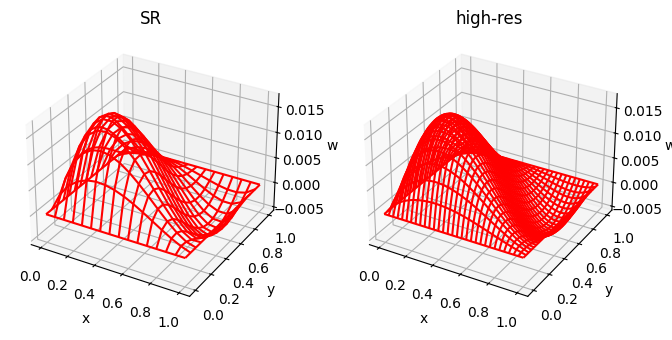

In [10]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, w_low[2],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high[8],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

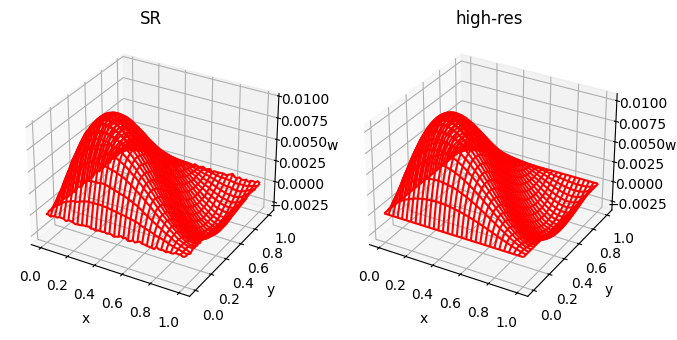

In [66]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy()[4],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high[4],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

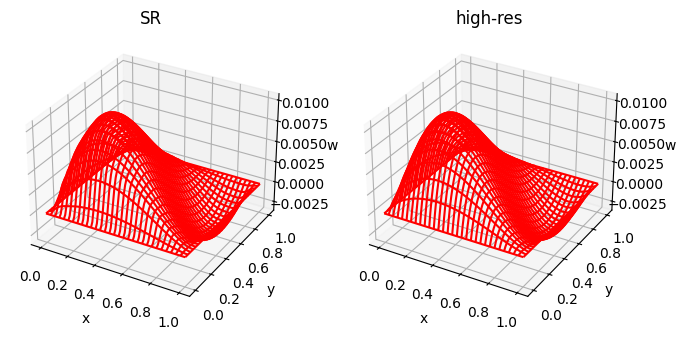

In [67]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, SR[4],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high[4],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

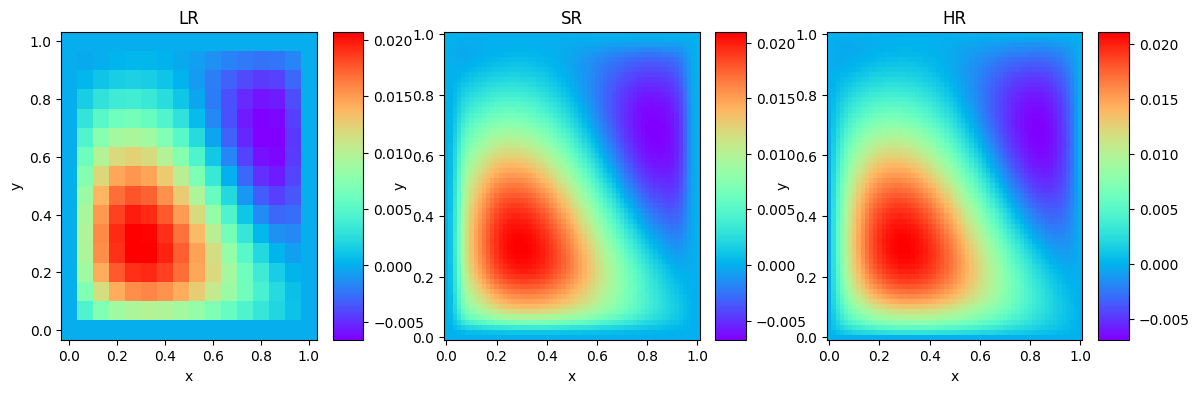

In [20]:
fig = plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_low,y_low,w_low[3], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
plt.pcolormesh(x_high, y_high, SR[12], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high[12], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
MSE = (error1**2).sum()/error1.shape[0]**2
print('SR L2 Error:', MSE)

SR L2 Error: 1.949910140883348e-06


In [12]:
error1 = abs(w_high - SR)
MSE = (error1**2).sum()/error1.shape[0]**2
print('SR L2 Error:', MSE)

SR L2 Error: 9.765462467361067e-06


In [15]:
10 * np.log(w_high.max()**2 / 1.095 * 10**6)

61.52013412461061

In [14]:
w_high.max()

0.022699148173788413

In [16]:
import numpy as np
import scipy.ndimage

def trilinear_interpolation(data, zoom_factors):
    """
    Perform trilinear interpolation on a 3D array.

    Parameters:
    data (3D array): The input data to be interpolated.
    zoom_factors (tuple of floats): The zoom factors for each dimension (z, y, x).

    Returns:
    3D array: The interpolated data.
    """
    return scipy.ndimage.zoom(data, zoom_factors, order=3)

# 示例数据
data = np.random.rand(4, 4, 4)  # 生成一个 4x4x4 的随机数组

# 插值因子
zoom_factors = (2, 2, 2)  # 将数据在每个维度上放大2倍

# 进行三维三次插值
interpolated_data = trilinear_interpolation(data, zoom_factors)

print("原始数据形状：", data.shape)
print("插值后数据形状：", interpolated_data.shape)


原始数据形状： (4, 4, 4)
插值后数据形状： (8, 8, 8)
